In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_json('/kaggle/input/synthetic-influencer-backstory/influencer_data.jsonl',lines=True)

In [3]:
df.head()

,Name,Age,Sex,Country of Origin,State or Province,Education Level,MBTI Personality,Lifestyle,Backstory
0,Andre Mcclain,23,male,USA,South Carolina,High School,INFP,architecture,Andre Mcclain grew up in a small town in South...
1,Gregory Joseph,19,male,USA,Iowa,High School,ISFP,diy,Gregory Joseph was born and raised in a small ...
2,William Wall,23,male,USA,Oregon,High School,ISFP,pets,William Wall was born and raised in the lush g...
3,Virginia Chapman,24,female,USA,Pennsylvania,Bachelor,ISFJ,cooking,Virginia Chapman was born and raised in a smal...
4,Deborah Potter,33,female,Canada,Quebec,Bachelor,ESTP,dancing,"Deborah Potter was born and raised in Quebec, ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32890 entries, 0 to 32889
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               32890 non-null  object
 1   Age                32890 non-null  int64 
 2   Sex                32890 non-null  object
 3   Country of Origin  32890 non-null  object
 4   State or Province  32890 non-null  object
 5   Education Level    32890 non-null  object
 6   MBTI Personality   32890 non-null  object
 7   Lifestyle          32890 non-null  object
 8   Backstory          32890 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.5+ MB


In [5]:
df.describe()

,Age
count,32890.000000
mean,24.344482
std,4.825563
min,18.000000
25%,21.000000
50%,23.000000
75%,27.000000
max,51.000000


In [6]:
df.isna().sum()

Name                 0
Age                  0
Sex                  0
Country of Origin    0
State or Province    0
Education Level      0
MBTI Personality     0
Lifestyle            0
Backstory            0
dtype: int64

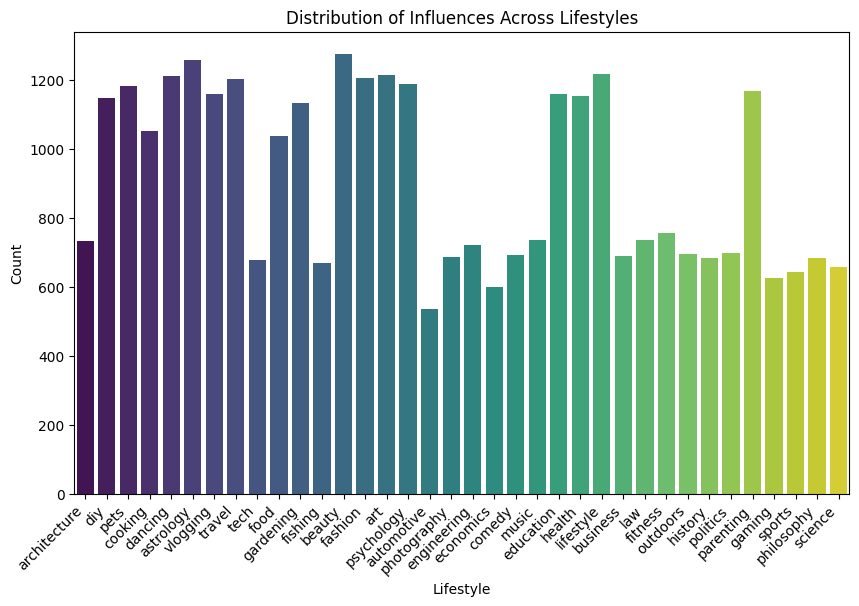

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.countplot(x='Lifestyle',data=df,palette='viridis')
plt.title('Distribution of Influences Across Lifestyles')
plt.xlabel('Lifestyle')
plt.ylabel('Count')
plt.xticks(rotation=45,ha='right')
plt.show()

In [8]:
fig=px.histogram(df,x='Age',color='Sex',marginal='box',title='Distribution of Age of Gender',labels={'Age':'Age of Influncers','count':'Number of Influencers'},
                template='plotly_dark')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [9]:
fig.show()

In [10]:
fig=px.pie(df,names='MBTI Personality',title='MBTI Personality Distribution',labels={'MBTI Personality':'Personality Type'},
           template='plotly_dark')

In [11]:
fig.show()

In [12]:
fig=px.scatter_matrix(df,dimensions=['Age','Education Level'],
                     color='MBTI Personality',title='Scattter Plot Matrix',
                     labels={'Age':'Age of influencers','Education level':'Level of Education'},
                     template='plotly_dark')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [13]:
fig.show()

In [14]:
fig = px.box(df, x='MBTI Personality', y='Age', title='Distribution of Ages by MBTI Personality',
             labels={'Age': 'Age of Influencers', 'MBTI Personality': 'Personality Type'},
             template='plotly_dark')

fig.show()

In [15]:
fig = px.sunburst(df, path=['Country of Origin', 'Education Level', 'MBTI Personality'],
                  title='Sunburst Chart of Influencers',
                  labels={'Country of Origin': 'Country', 'Education Level': 'Education Level'},
                  template='plotly_dark')

fig.show()

In [16]:
le=LabelEncoder()
df['Education Level Numeric']=le.fit_transform(df['Education Level'])

In [17]:
fig = px.scatter(df, x='Age', y='Education Level Numeric', color='MBTI Personality', trendline='ols',
                 title='Scatter Plot of Age vs. Education Level',
                 labels={'Age': 'Age of Influencers', 'Education Level Numeric': 'Numeric Education Level'},
                 template='plotly_dark')

fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [18]:
country_counts = df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['Country of Origin', 'Count']

fig = px.choropleth(country_counts, 
                    locations='Country of Origin',
                    title='Influencers Distribution by Country',
                    template='plotly_dark',
                    locationmode='country names',
                    color='Count',
                    color_continuous_scale='Viridis',  # You can customize the color scale
                    labels={'Count': 'Number of Influencers'})

fig.update_geos(projection_type="natural earth")
fig.show()

In [25]:
# Drop the target variable from features
X = df.drop(['Education Level','Name','Backstory'], axis=1)

# Target variable
y = df['Education Level'].astype(str)  # Convert to string

# Define categorical features for encoding
categorical_features = ['Sex', 'Country of Origin', 'State or Province', 'MBTI Personality', 'Lifestyle']

# Create a column transformer for encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features),
        # Add more transformers if needed for numerical features
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))

Accuracy: 1.00
                precision    recall  f1-score   support

      Bachelor       1.00      1.00      1.00      1786
   High School       1.00      1.00      1.00      3178
        Master       1.00      0.99      0.99       459
No High School       0.98      1.00      0.99      1062
           PhD       1.00      0.73      0.84        93

      accuracy                           1.00      6578
     macro avg       0.99      0.94      0.96      6578
  weighted avg       1.00      1.00      0.99      6578



In [26]:
label_encoder=LabelEncoder()
y_train_encoder=label_encoder.fit_transform(y_train)
y_test_encoder=label_encoder.fit_transform(y_test)

In [28]:
xgb_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',XGBClassifier(random_state=42))
])

In [29]:
xgb_pipeline.fit(X_train,y_train_encoder)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Sex', 'Country of Origin',
                                                   'State or Province',
                                                   'MBTI Personality',
                                                   'Lifestyle'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, dev...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [30]:
xgb_y_pred=xgb_pipeline.predict(X_test)

In [31]:
xgb_accuracy=accuracy_score(y_test_encoder,xgb_y_pred)

In [32]:
print(f"XGBBoost Accuracy:{xgb_accuracy:.2f}")

XGBBoost Accuracy:1.00


In [33]:
print(classification_report(y_test_encoder,xgb_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1786
           1       1.00      1.00      1.00      3178
           2       1.00      1.00      1.00       459
           3       1.00      1.00      1.00      1062
           4       1.00      1.00      1.00        93

    accuracy                           1.00      6578
   macro avg       1.00      1.00      1.00      6578
weighted avg       1.00      1.00      1.00      6578

